<div>
<img src="https://drive.google.com/uc?export=view&id=1vK33e_EqaHgBHcbRV_m38hx6IkG0blK_" width="350"/>
</div> 

#**Artificial Intelligence - MSc**
##ET5003 - MACHINE LEARNING APPLICATIONS 

###Instructor: Enrique Naredo
###ET5003_Etivity-2

In [1]:
#@title Current Date
Today = '2021-10-3' #@param {type:"date"}


In [2]:
#@markdown ---
#@markdown ### Enter your details here:
Student_ID = "John Hayes" #@param {type:"string"}
Student_full_name = "9309888" #@param {type:"string"}
#@markdown ---

In [3]:
#@title Notebook information
Notebook_type = 'Etivity' #@param ["Example", "Lab", "Practice", "Etivity", "Assignment", "Exam"]
Version = 'Final' #@param ["Draft", "Final"] {type:"raw"}
Submission = True #@param {type:"boolean"}

# INTRODUCTION

**Piecewise regression**, extract from [Wikipedia](https://en.wikipedia.org/wiki/Segmented_regression):

Segmented regression, also known as piecewise regression or broken-stick regression, is a method in regression analysis in which the independent variable is partitioned into intervals and a separate line segment is fit to each interval. 

* Segmented regression analysis can also be performed on 
multivariate data by partitioning the various independent variables. 
* Segmented regression is useful when the independent variables, clustered into different groups, exhibit different relationships between the variables in these regions. 

* The boundaries between the segments are breakpoints.

* Segmented linear regression is segmented regression whereby the relations in the intervals are obtained by linear regression. 

***The goal is to use advanced Machine Learning methods to predict House price.***

## Imports

In [4]:
# Suppressing Warnings:
import warnings
warnings.filterwarnings("ignore")

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm
import arviz as az

from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [6]:
# to plot
import matplotlib.colors
from mpl_toolkits.mplot3d import Axes3D

# to generate classification, regression and clustering datasets
import sklearn.datasets as dt

# For feature importance
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestRegressor

# to create data frames
from pandas import DataFrame

# to generate data from an existing dataset
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import fetch_openml

import seaborn as sns
import geopandas as gpd

import datetime

#### Any functions that will be used later on

In [7]:
def run_model(x_data, y_data, iterations, sample_size, text=None):
    """
    Execute the model for a given data set
    """
    
    if text != None:
        print(text)
    
    with pm.Model() as model:
        
        # prior over the parameters of linear regression
        alpha = pm.Normal('alpha', mu=0, sigma=30)
  
        # we have a beta for each column of Xn0
        beta = pm.Normal('beta', mu=0, sigma=30, shape=x_data.shape[1])
  
        # prior over the variance of the noise
        sigma = pm.HalfCauchy('sigma_n', 5)
  
        # linear regression relationship
        # linear regression model in matrix form
        mu = alpha + pm.math.dot(beta, x_data.T)
        
        # likelihood, be sure that observed is a 1d vector
        like = pm.Normal('like', mu=mu, sigma=sigma, observed=y_data[:,0])
        
    with model:
        
        # iterations of the algorithm
        approximation = pm.fit(iterations,method='advi')

    # samples from the posterior   
    posterior = approximation.sample(sample_size)
    
    return posterior, approximation


#------------------------------------------------------------
def ppc(alpha, beta, sigma, X, nsamples=500):
    """
    Posterior predictive checks (PPCs)
    """
    
    # Select nsamples random samples from the posterior
    ind = np.random.randint(0,beta.shape[0],size=nsamples)
    alphai = alpha[ind]
    betai = beta[ind,:]
    sigmai = sigma[ind]

    Ypred = np.zeros((nsamples,X.shape[0]))
    for i in range(X.shape[0]):
        
        # we generate data from linear model
        y_pred = alphai + np.dot(betai, X[i:i+1,:].T).T + \
                                    np.random.randn(len(sigmai))*sigmai
        Ypred[:,i]=y_pred[0,:]
        
    return Ypred


#------------------------------------------------------------
def train_cluster(x_train, x_test, clust_num):
    """
    Train the cluster
    """
    
    Xn = x_train[clusters_train==clust_num,:]
    Xtestn = x_test[clusters_test==clust_num,:]

    ylog = np.log(ys_train.astype('float')[clusters_train==clust_num,:])
    yscaler = StandardScaler().fit(ylog)
    yn = yscaler.transform(ylog)
    
    return ylog, yscaler, Xn, yn, Xtestn, yscaler


#------------------------------------------------------------
def plot_redictions(y_pred, ylog, title=None):
    
    plt.figure(figsize=(9,8))
    for i in range(y_pred.shape[0]):
        az.plot_dist( y_pred[i,:],color='r',plot_kwargs={"linewidth": 0.2})
        
    az.plot_dist(y_pred[i,:],color='r',
                 plot_kwargs={"linewidth": 0.2},
                 label="prediction")
    
    az.plot_dist(ylog, label='true observations');
    if title != None:
        plt.title(title)
        
    plt.legend()
    plt.xlabel("log(y) - output variable")
    plt.ylabel("density plot");


#------------------------------------------------------------
def cluster_sim(posterior, Xn, ylog, title=None, num_samples=200):
    """
    Display a prediction for a single cluster
    """
    
    # Simulation
    Ypred = yscaler.inverse_transform(ppc(posterior['alpha'],
                                            posterior['beta'],
                                            posterior['sigma_n'],
                                            Xn,
                                            nsamples=num_samples))
    plot_redictions(Ypred, ylog, title)
    

#------------------------------------------------------------
def create_heat_map(data):
    """
    Create a correlation matrix
    """
    
    # Plot the heatmap. The numbers are easier to read IMO
    corr = data.corr()
    fig, ax = plt.subplots(figsize=(10,10))   
    sns.heatmap(corr,
            xticklabels=corr.columns,
            yticklabels=corr.columns,
            annot=True,
            cmap=sns.diverging_palette(220, 20, as_cmap=True),
            ax=ax)
    

In [8]:
print("Start time {}".format(datetime.datetime.now().time()))

Start time 11:24:44.829993


#### Some variables that will be used throughout

In [9]:
num_iter = 50000
sample_size = 5000
num_of_clust_samples = 200

# Define the seed so that results can be reproduced
seed = 11
rand_state = 11

# Define the color maps for plots
color_map = plt.cm.get_cmap('RdYlBu')
color_map_discrete = matplotlib.colors.LinearSegmentedColormap.from_list("",
                                                ["red","cyan","magenta","blue"])

# Dataset <a id='the_dataset'></a>

Extract from this [paper](https://ieeexplore.ieee.org/document/9300074):

* House prices are a significant impression of the economy, and its value ranges are of great concerns for the clients and property dealers. 

* Housing price escalate every year that eventually reinforced the need of strategy or technique that could predict house prices in future. 

* There are certain factors that influence house prices including physical conditions, locations, number of bedrooms and others.


1. [Download the dataset](https://github.com/UL-ET5003/ET5003_SEM1_2021-2/tree/main/Week-3). 

2. Upload the dataset into your folder.



#### The challenge is to predict the final price of each house.

#### Data description/analysis
* I found the `description` and `features` data to be of no use due to the fact that there was large amounts of text in it with very little in common that I could reduce down to and use. If I have more time I may be able to apply a value to the missing `property_type` but my application of a single value to that from a possible range in the `descriptions` could be incorrect and would alter the data.
* For both the training and test set the `environment` was set to 1 value - `prod`, I have ignored that for now.
* For `property_type` I used a simple mapping to convert it from categorical to integer. Less that 60 or so values are not set for this, so I think it is worth keeping. It is similar for `bathrooms`, `beds` and `ber_classification`.



#### Load the dataset <a id='loading_dataset'></a>
Using a generic loader for local and colab based notebook only works when the data has a unique ID such as the MNIST dataset. The house data doesn't AFAIK

In [10]:
RunningInCOLAB = 'google.colab' in str(get_ipython())

if RunningInCOLAB:
    from google.colab import drive
    drive.mount('/content/drive')
    
    # Path, copy the path from your Drive
    Path = '/content/drive/MyDrive/Colab Notebooks/Etivity2-Data/'
    
else:
    Path = "./"
    
# House price data from csv files
train_data = Path + 'house_train.csv'
test_data = Path + 'house_test.csv'
true_price_data = Path + 'true_price.csv'

# Can't drop the ad id as it is linked to the true data
# Training data
df_orig_train_data = pd.read_csv(train_data)
X_train = df_orig_train_data.values
print("Testing data {}".format(X_train.shape))

# Test data
df_test_data = pd.read_csv(test_data)
X_test = df_test_data.values
print("Test data {}".format(X_test.shape))

# True data
df_true_cost = pd.read_csv(true_price_data)
X_true = df_true_cost.values
print("True prices data {}".format(X_true.shape))


Testing data (2982, 17)
Test data (500, 16)
True prices data (500, 2)


#### Features used summary
Having looked at all the headings (`ad_id, area, bathrooms, beds, ber_classification, county, description_block, environment, facility, features, latitude, longitude, no_of_units, price, property_category, property_type, surface`) and the data for each of those in the training set, I have decided to use:
* `latitude` and `lognitue` as suggested by the Etivity
* `ber_classification` and `property_type` after conversion as well as `beds` and `bathrooms`.

More details are in the [data_preparation](#data_preparation) below.

## Training & Test Data

### Train dataset <a id='training_dataset'></a>

In [11]:
# Lets see some details on the training data
df_orig_train_data.describe(include='all')

,ad_id,area,bathrooms,beds,ber_classification,county,description_block,environment,facility,features,latitude,longitude,no_of_units,price,property_category,property_type,surface
count,2.982000e+03,2982,2931.000000,2931.000000,2305,2982,2982,2982,965,2982,2982.000000,2982.000000,59.000000,2.892000e+03,2982,2931,2431.000000
unique,NaN,156,NaN,NaN,16,1,2978,1,34,1882,NaN,NaN,NaN,NaN,2,10,NaN
top,NaN,Finglas,NaN,NaN,D1,Dublin,LEONARD WILSON KEENAN ESTATE &amp; LETTING AGE...,prod,"Parking,Gas Fired Central Heating",None,NaN,NaN,NaN,NaN,sale,apartment,NaN
freq,NaN,94,NaN,NaN,283,2982,2,2982,184,1095,NaN,NaN,NaN,NaN,2923,759,NaN
mean,1.224065e+07,NaN,1.998635,2.979188,NaN,NaN,NaN,NaN,NaN,NaN,53.355991,-6.257175,7.440678,5.323536e+05,NaN,NaN,318.851787
std,5.793037e+05,NaN,1.291875,1.468408,NaN,NaN,NaN,NaN,NaN,NaN,0.086748,0.141906,8.937081,5.678148e+05,NaN,NaN,4389.423136
min,9.968870e+05,NaN,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,51.458439,-6.521183,0.000000,1.999500e+04,NaN,NaN,3.400000
25%,1.226813e+07,NaN,1.000000,2.000000,NaN,NaN,NaN,NaN,NaN,NaN,53.298929,-6.314064,2.000000,2.800000e+05,NaN,NaN,74.100000
50%,1.237758e+07,NaN,2.000000,3.000000,NaN,NaN,NaN,NaN,NaN,NaN,53.345497,-6.252254,3.000000,3.800000e+05,NaN,NaN,100.000000
75%,1.240294e+07,NaN,3.000000,4.000000,NaN,NaN,NaN,NaN,NaN,NaN,53.388845,-6.196049,8.000000,5.750000e+05,NaN,NaN,142.000000


In [12]:
# show first data frame rows 
df_orig_train_data.head()

,ad_id,area,bathrooms,beds,ber_classification,county,description_block,environment,facility,features,latitude,longitude,no_of_units,price,property_category,property_type,surface
0,996887,Portmarnock,NaN,NaN,NaN,Dublin,A SELECTION OF 4 AND 5 BEDROOM FAMILY HOMES LO...,prod,NaN,None,53.418216,-6.149329,18.0,NaN,new_development_parent,NaN,NaN
1,999327,Lucan,NaN,NaN,NaN,Dublin,**Last 2 remaining houses for sale ***\n\nOn v...,prod,NaN,None,53.364917,-6.454935,3.0,NaN,new_development_parent,NaN,NaN
2,999559,Rathfarnham,NaN,NaN,NaN,Dublin,Final 4 &amp; 5 Bedroom Homes for Sale\n\nOn V...,prod,NaN,None,53.273447,-6.313821,3.0,NaN,new_development_parent,NaN,NaN
3,9102986,Balbriggan,NaN,NaN,NaN,Dublin,"Glenveagh Taylor Hill, Balbriggan\n\r\n*Ideal ...",prod,NaN,None,53.608167,-6.210914,30.0,NaN,new_development_parent,NaN,NaN
4,9106028,Foxrock,NaN,NaN,NaN,Dublin,*New phase launching this weekend Sat &amp; Su...,prod,NaN,None,53.262531,-6.181527,8.0,NaN,new_development_parent,NaN,NaN


An examination of the file shows 2982 as the total (data) line count, so the 2305 for `ber_classification` will have to be examined.

In [13]:
df_orig_train_data.isna().sum()

ad_id                    0
area                     0
bathrooms               51
beds                    51
ber_classification     677
county                   0
description_block        0
environment              0
facility              2017
features                 0
latitude                 0
longitude                0
no_of_units           2923
price                   90
property_category        0
property_type           51
surface                551
dtype: int64

In [14]:
df_orig_train_data['beds'].value_counts()

3.0     1009
2.0      806
4.0      583
1.0      209
5.0      187
0.0       56
6.0       44
7.0       20
9.0        4
8.0        4
15.0       3
11.0       2
27.0       2
14.0       1
10.0       1
Name: beds, dtype: int64

In [15]:
df_orig_train_data['ber_classification'].value_counts()

D1                     283
D2                     274
C3                     268
C2                     242
C1                     212
E1                     182
E2                     169
G                      166
F                      165
B3                     130
B2                      74
A3                      70
SINo666of2006exempt     28
A2                      25
B1                      16
A1                       1
Name: ber_classification, dtype: int64

In [16]:
df_orig_train_data['property_type'].value_counts()

apartment         759
semi-detached     754
terraced          554
detached          398
end-of-terrace    237
bungalow           84
duplex             60
site               55
townhouse          27
studio              3
Name: property_type, dtype: int64

### Test dataset <a id='test_dataset'></a>

In [17]:
df_test_data.describe(include='all')

,ad_id,area,bathrooms,beds,ber_classification,county,description_block,environment,facility,features,latitude,longitude,no_of_units,property_category,property_type,surface
count,5.000000e+02,500,500.000000,500.000000,444,500,500,500,189,500,500.000000,500.000000,0.0,500,500,500.000000
unique,NaN,119,NaN,NaN,15,1,500,1,21,500,NaN,NaN,NaN,1,10,NaN
top,NaN,Castleknock,NaN,NaN,D1,Dublin,"It's all in the name ""Island View"";. Truly won...",prod,"Parking,Gas Fired Central Heating",Breath-taking panoramic views radiate from thi...,NaN,NaN,NaN,sale,semi-detached,NaN
freq,NaN,16,NaN,NaN,63,500,1,500,30,1,NaN,NaN,NaN,500,135,NaN
mean,1.231695e+07,NaN,1.994000,2.930000,NaN,NaN,NaN,NaN,NaN,NaN,53.356034,-6.247842,NaN,NaN,NaN,156.007671
std,1.485832e+05,NaN,1.106532,1.191612,NaN,NaN,NaN,NaN,NaN,NaN,0.081905,0.088552,NaN,NaN,NaN,344.497362
min,1.130615e+07,NaN,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,53.221348,-6.496987,NaN,NaN,NaN,33.500000
25%,1.228617e+07,NaN,1.000000,2.000000,NaN,NaN,NaN,NaN,NaN,NaN,53.297373,-6.296404,NaN,NaN,NaN,72.375000
50%,1.237964e+07,NaN,2.000000,3.000000,NaN,NaN,NaN,NaN,NaN,NaN,53.339547,-6.243572,NaN,NaN,NaN,98.000000
75%,1.240544e+07,NaN,3.000000,4.000000,NaN,NaN,NaN,NaN,NaN,NaN,53.381650,-6.185055,NaN,NaN,NaN,138.935000


An examination of thetest data csv file does show 500 data lines.

In [18]:
# show first data frame rows 
df_test_data.head()

,ad_id,area,bathrooms,beds,ber_classification,county,description_block,environment,facility,features,latitude,longitude,no_of_units,property_category,property_type,surface
0,12373510,Skerries,2.0,4.0,G,Dublin,"It's all in the name ""Island View"";. Truly won...",prod,"Parking,Alarm,Oil Fired Central Heating",Breath-taking panoramic views radiate from thi...,53.566881,-6.101148,NaN,sale,bungalow,142.0
1,12422623,Lucan,2.0,3.0,C1,Dublin,REA McDonald - Lucan' s longest established es...,prod,NaN,Gas fired central heating.\nDouble glazed wind...,53.362992,-6.452909,NaN,sale,terraced,114.0
2,12377408,Swords,3.0,4.0,B3,Dublin,REA Grimes are proud to present to the market ...,prod,NaN,Pristine condition throughout\nHighly sought-a...,53.454198,-6.262964,NaN,sale,semi-detached,172.0
3,12420093,Lucan,4.0,3.0,A3,Dublin,"REA McDonald, Lucan' s longest established est...",prod,NaN,A-rated home within a short walk of Lucan Vill...,53.354402,-6.458647,NaN,sale,semi-detached,132.4
4,12417338,Clondalkin,1.0,3.0,E2,Dublin,"Hibernian Auctioneers are delighted to bring, ...",prod,"Parking,Gas Fired Central Heating,Wired for Ca...",Mature Location \nGas Heating \nClose to Ameni...,53.336530,-6.393587,NaN,sale,semi-detached,88.0


In [19]:
df_test_data.isna().sum()

ad_id                   0
area                    0
bathrooms               0
beds                    0
ber_classification     56
county                  0
description_block       0
environment             0
facility              311
features                0
latitude                0
longitude               0
no_of_units           500
property_category       0
property_type           0
surface                 0
dtype: int64

### Expected Cost dataset

In [20]:
# Generate descriptive statistics
df_true_cost.describe(include='all')

,Id,Expected
count,5.000000e+02,5.000000e+02
mean,1.231695e+07,5.810356e+05
std,1.485832e+05,6.009194e+05
min,1.130615e+07,8.500000e+04
25%,1.228617e+07,2.950000e+05
50%,1.237964e+07,4.250000e+05
75%,1.240544e+07,5.950000e+05
max,1.242809e+07,5.750000e+06


In [21]:
df_true_cost.head()

,Id,Expected
0,12373510,875000.0
1,12422623,355000.0
2,12377408,440000.0
3,12420093,425000.0
4,12417338,265000.0


### Display some information on some of the values I've chosen

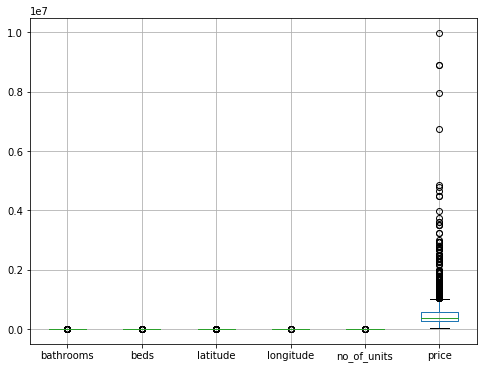

In [22]:
# Display a range from start : finish
df_orig_train_data.loc[:,'area':'property_type'].boxplot(figsize=(8,6))
plt.show()

So the above has too much information in it, so reduce the comparision.

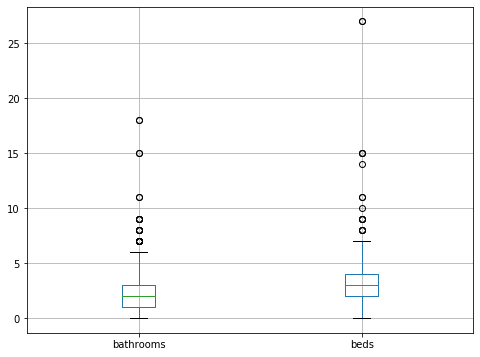

In [23]:
# Display a range from start : finish
df_orig_train_data.loc[:,'area':'county'].boxplot(figsize=(8,6))
plt.show()

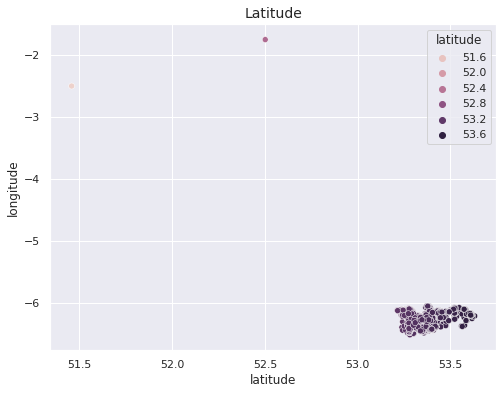

In [24]:
sns.set(rc={'figure.figsize':(8,6)})

sns.scatterplot(data=df_orig_train_data,x='latitude', y='longitude', hue='latitude')
plt.title("Latitude", fontsize=14)
plt.show()

They are supposed to be all based in Dublin, so what are the 2 outliers ?<br>
* One of them is on line 893 (51.4584386 -2.4962188)- and that maps to 61 Bellevue Rd, Bristol BS15 9TU, UK
* The second is on line 769 (52.5018563 -1.744995) and maps to 34-12 Wheatfield Cl, Birmingham B36 0QP, UK

They are a 1 and 2 bed units and from the counts (209 & 806), removing 1 from each of these is acceptable IMO.

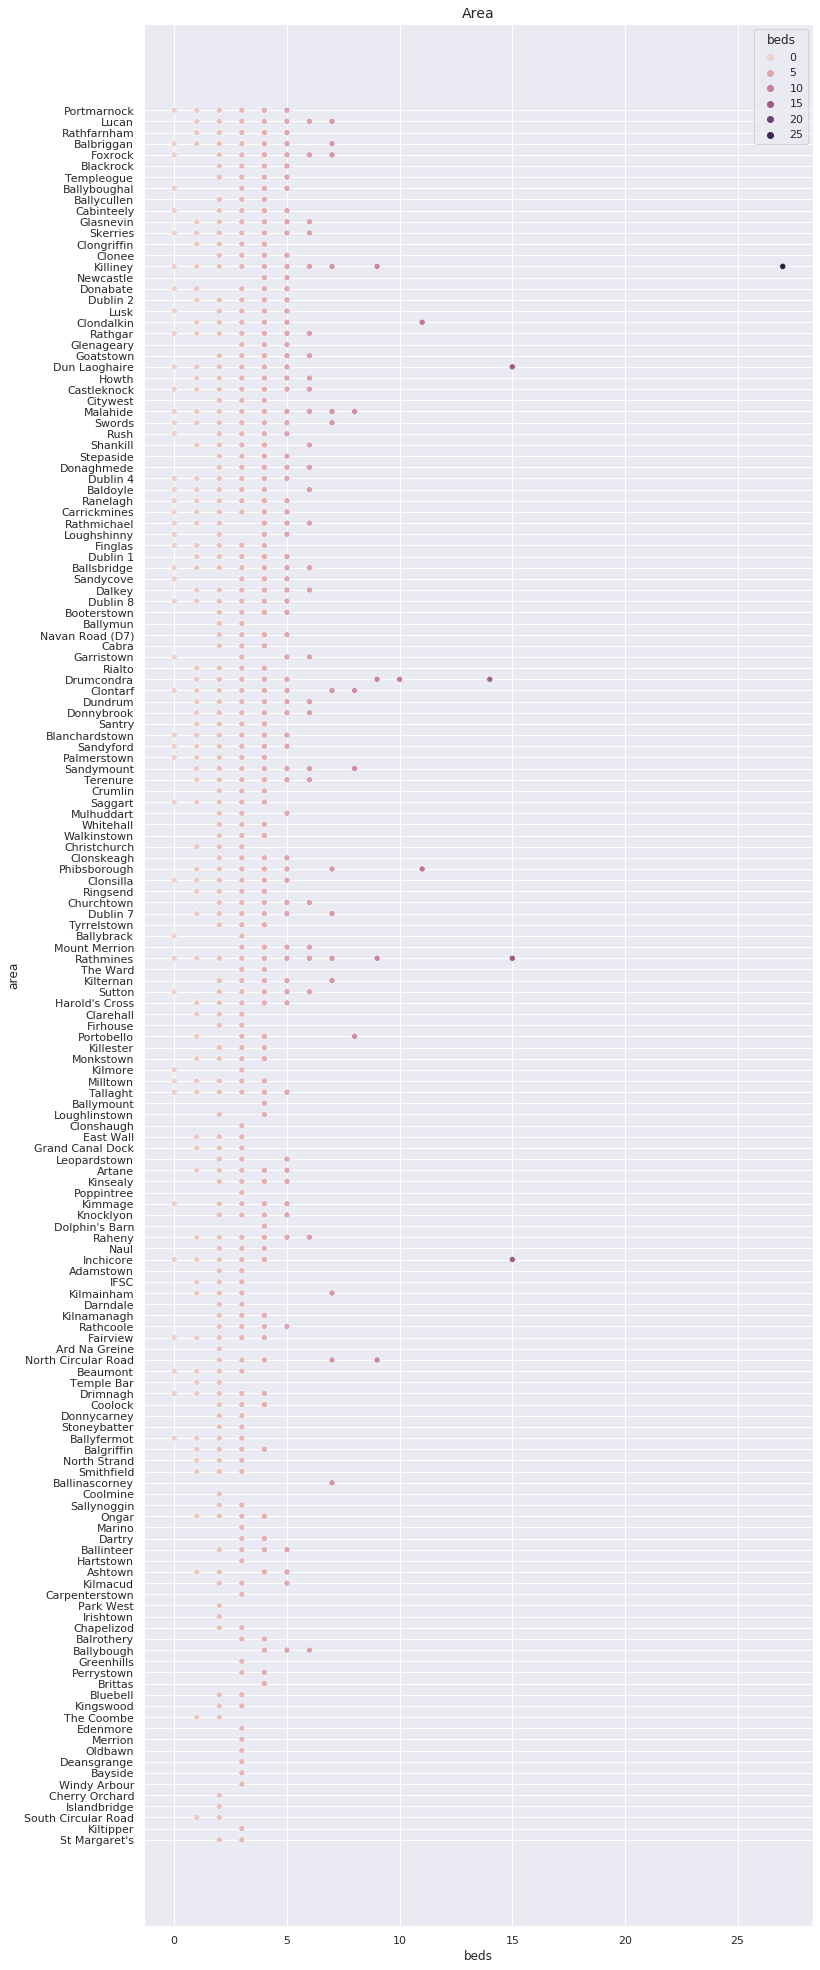

In [25]:
sns.set(rc={'figure.figsize':(12,35)})

sns.scatterplot(data=df_orig_train_data,x='beds', y='area', hue='beds')
plt.title("Area", fontsize=14)
plt.show()

I think it would be better if I could have the areas displayed on a map. May look at that if time permits.

In [26]:
# Reset the general size of the plots as the above was an exception required for the 'area'
sns.set(rc={'figure.figsize':(9,9)})

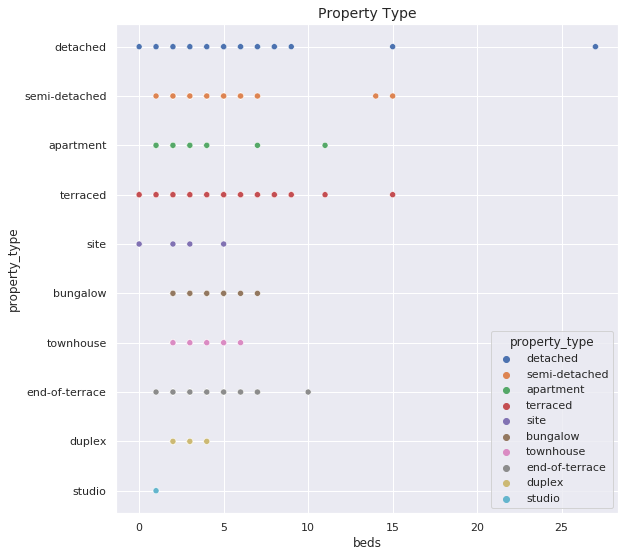

In [27]:
sns.scatterplot(data=df_orig_train_data,x='beds', y='property_type', hue='property_type')
plt.title("Property Type", fontsize=14)
plt.show()

It might also be worth clustering the data based on a set number of beds to get better indication of various groups of house sizes. Dropping anything with 0 beds should also remove the `sites` from the dataset.

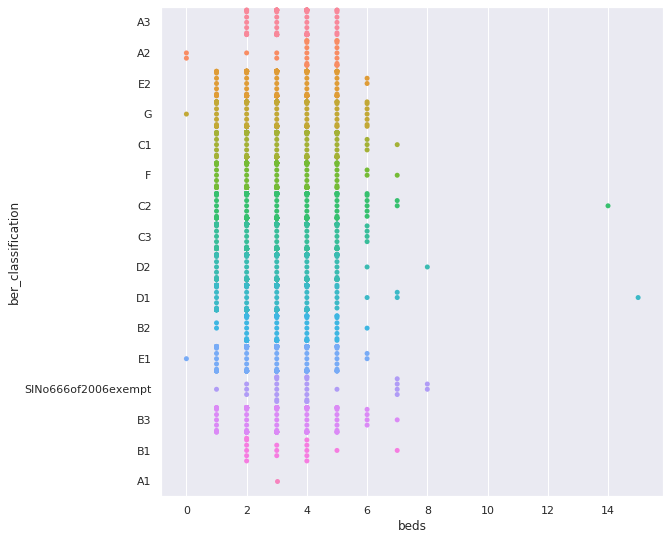

In [28]:
sns.swarmplot(data=df_orig_train_data, x='beds', y='ber_classification')
plt.show()

From the above, there is a fairly consistent spread of classification across the size range, so I am not sure yet what benefit `ber_classification` may bring. From the dataset, anything listed as a new development has an A rating. Mapping it against the price (below) doesn't show you might pay more for a better rating (**based on that comparision alone**). I think a better mapping for the classification would be build date if it was present in the dataset.

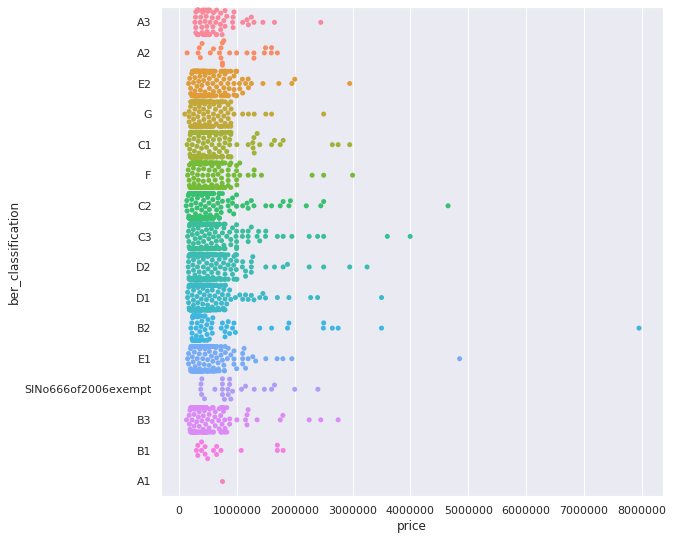

In [29]:
sns.swarmplot(data=df_orig_train_data, x='price', y='ber_classification')
plt.show()

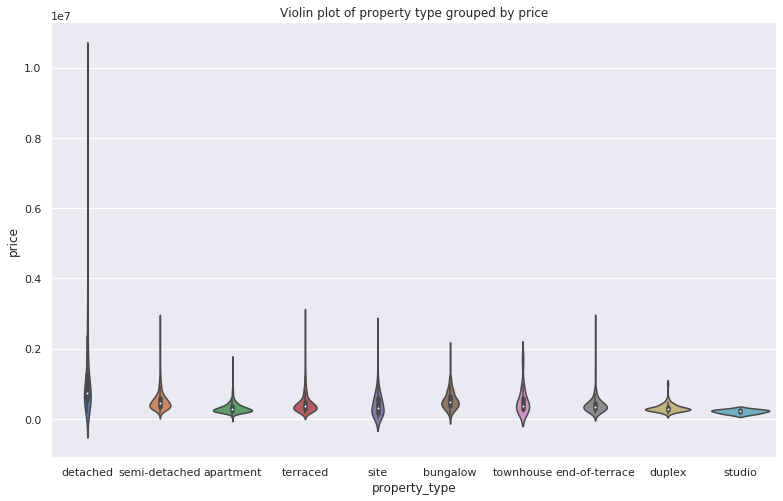

In [30]:
sns.set(rc={'figure.figsize':(13,8)})
sns.violinplot(data=df_orig_train_data, x='property_type', y='price', split=True)
plt.title('Violin plot of property type grouped by price')
plt.show()

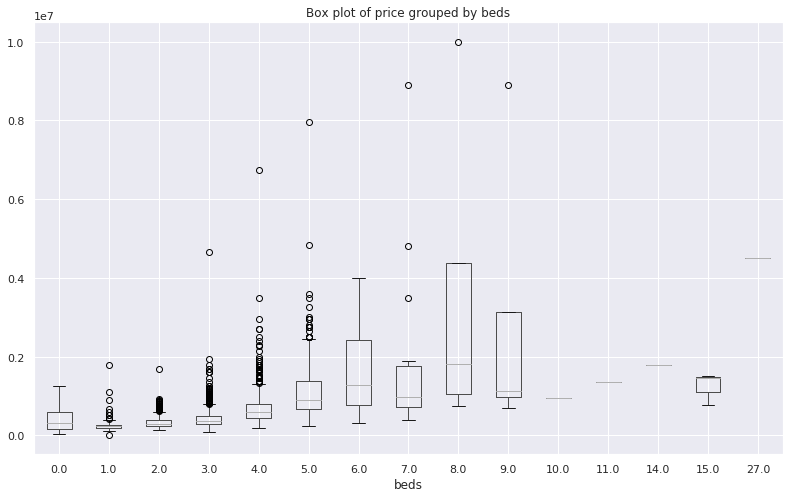

In [31]:
df_orig_train_data.boxplot(column='price', by='beds')
plt.title('Box plot of price grouped by beds')
plt.suptitle("")
plt.show()

Display a correlation matrix on the training dataset to see if there are any relationships between the different features.

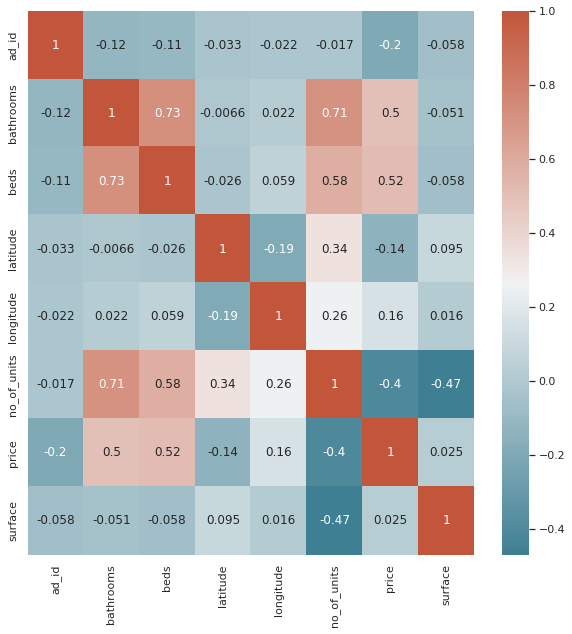

In [32]:
create_heat_map(df_orig_train_data)

The way to interpret the results is, the closer they are to 1, the stronger the correlation is between those 2 values. For example, there is a correlation between the `price` and the number of `beds` (0.52) but a stronger correlation between the number of `bathrooms` and the `no_of_units` (0.71).

In [33]:
df_orig_train_data['surface'].min()

3.4

In [34]:
df_orig_train_data['surface'].max()

182108.539008

### Data Preparation <a id='data_preparation'></a>
* Remove anything with more than 6 beds and those that have no number specified.
* Remove anything with no `property_type` value set.
* Remove anything with no `bathroom` value set.
* Drop the `environment` column as I see no value in it.
* Drop `no_of_units` as it has more than 500 missing from almost 3000.
* Drop `facility` - not sure what value this is going to give, given the varying type of data it holds. Same applies to `property_category` and `features`.
* Everything is in 'Dublin' so the `county` can be dropped too.
* Remove the 2 with the invalid long & lat
* From above there are 551 missing entries in `surface` but trying to find a value to use from the range of values could cause unwanted correlations. For now I will drop this column as I don't want to remove that number of rows by removing ones with no value.
* I am intentionally dropping sites (< 0 bathrooms) as I don't think they should be included when trying to determine house prices.


In [35]:
# Create a list of features to drop
drop_features = ['ad_id', 'description_block', 'environment', 'county', 'no_of_units', 'facility',
                 'property_category', 'features', 'surface']
df_train_new = df_orig_train_data.drop(columns=drop_features)

# Drop same columns from the test data set
df_test_new = df_test_data.drop(columns=drop_features)


Cleaning the `longitude` & `latitude` first for the plot below so the textual property type can be displayed in the legend.<br> <br>
Lets look again at the cleaned `latitude` and `longitude`.

In [36]:
# The 2 Longitude & latitude outliers from above
df_train_new = df_train_new.drop(df_train_new[(df_train_new.longitude > -5) |
                                              (df_train_new.latitude < 52)].index)

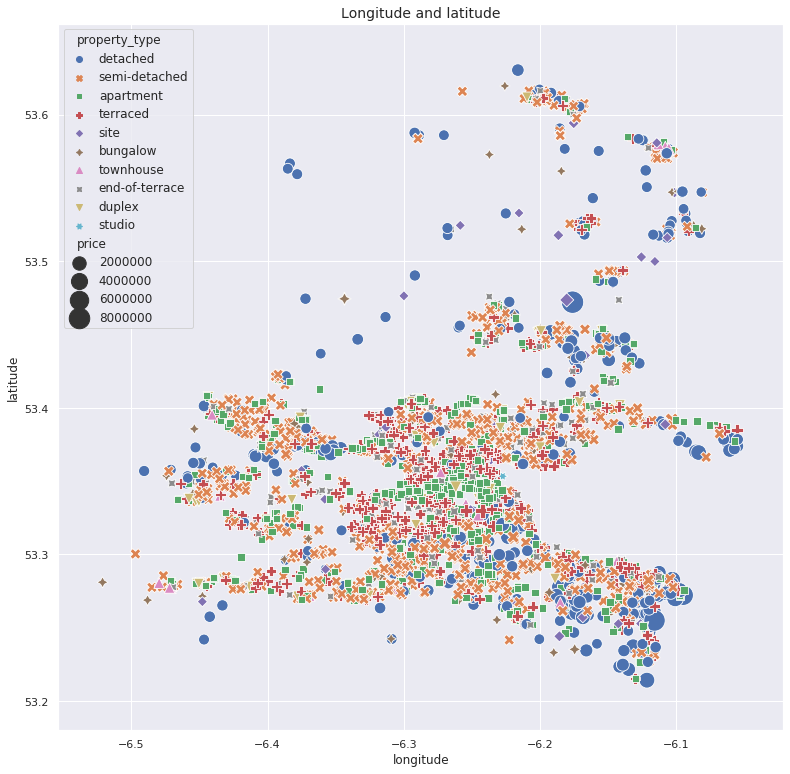

In [37]:
sns.set(rc={'figure.figsize':(13,13)})

sns.scatterplot(data=df_train_new,
                x='longitude',
                y='latitude',
                style='property_type',
                size="price",
                hue="property_type",
                sizes=(100, 500))

plt.title("Longitude and latitude", fontsize=14)
plt.show()

 You can picture a map of Dublin overlayed on the above plot. 53.35 is approximately the river Liffey, 53.4 is approximately Santry and 53.2 is Bray. -6.5 is around Newcastle.

#### Continue with the preperation <a id='continue_cleaning'></a>
Convert `ber_classification` and then `property_type` into numerical formats. I think the increasing number in `ber_classification` is justified as that what the classification is - I.E an increasing number means it uses more energy.

In [38]:
# Replace all ber values with equivalant decimal values. Last value is 'nan' so ignore that
df_train_new.dropna(subset=['ber_classification'], inplace=True)
ber_features = df_train_new['ber_classification'].sort_values().unique()

new_ber_values = np.arange(1, len(ber_features) + 1).tolist()

df_train_new['ber_classification'].replace(to_replace=ber_features,
                                      value=new_ber_values,
                                      inplace=True)

df_test_new.dropna(subset=['ber_classification'], inplace=True)
df_test_new['ber_classification'].replace(to_replace=ber_features,
                                      value=new_ber_values,
                                      inplace=True)


In [39]:
# Replace property type
replace_ptype_features = ['apartment', 'studio', 'duplex', 'townhouse', 'terraced', 'end-of-terrace',
                          'semi-detached', 'detached', 'bungalow', 'site' ]

replace_values = np.arange(1, len(replace_ptype_features) + 1).tolist()

# Apply basic conversion to the property type
df_train_new['property_type'].replace(to_replace=replace_ptype_features,
                                      value=replace_values,
                                      inplace=True)

df_test_new['property_type'].replace(to_replace=replace_ptype_features,
                                      value=replace_values,
                                      inplace=True)
                
# Remove columns with 0 - causes problems for the scalers used below
df_train_new = df_train_new[(df_train_new.beds>0)]

# Also drops all sites - this is intended
df_train_new = df_train_new[(df_train_new.bathrooms>0)]

df_train_new = df_train_new[(df_train_new.price>0)]

#### Now look at the data again after cleaning

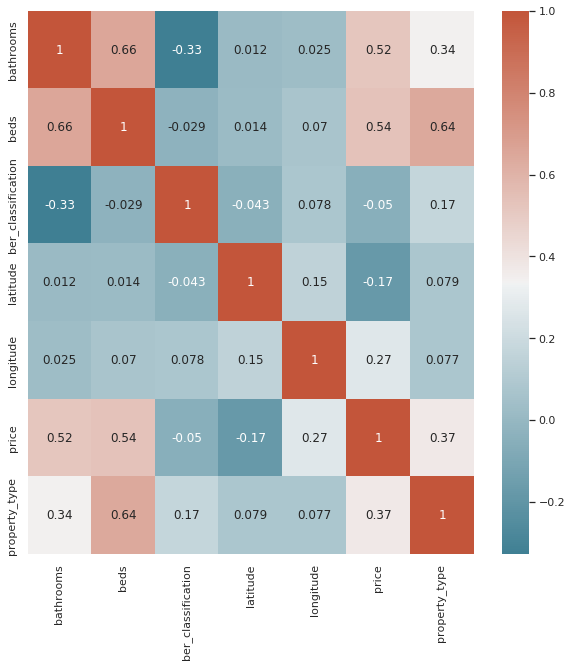

In [40]:
create_heat_map(df_train_new)

In [41]:
print("Cleaned training missing values")
df_train_new.isna().sum()

Cleaned training missing values


area                  0
bathrooms             0
beds                  0
ber_classification    0
latitude              0
longitude             0
price                 0
property_type         0
dtype: int64

In [42]:
df_train_new.describe(include='all')

,area,bathrooms,beds,ber_classification,latitude,longitude,price,property_type
count,2267,2267.000000,2267.000000,2267.000000,2267.000000,2267.000000,2.267000e+03,2267.000000
unique,146,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,Rathfarnham,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,80,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,2.029996,3.011028,9.880018,53.353191,-6.255785,5.295638e+05,5.045434
std,NaN,1.105622,1.185884,3.139685,0.077369,0.091700,4.492461e+05,2.709559
min,NaN,1.000000,1.000000,1.000000,53.215264,-6.521183,1.000000e+05,1.000000
25%,NaN,1.000000,2.000000,8.000000,53.294066,-6.309154,2.950000e+05,1.000000
50%,NaN,2.000000,3.000000,10.000000,53.342393,-6.247240,3.950000e+05,6.000000
75%,NaN,3.000000,4.000000,12.000000,53.384625,-6.189673,5.950000e+05,7.000000


After the cleaning, we still have 2826 entries from just under 3000, so this is still a good representation of the number of values from the dataset.

In [43]:
df_train_new.dtypes

area                   object
bathrooms             float64
beds                  float64
ber_classification      int64
latitude              float64
longitude             float64
price                 float64
property_type           int64
dtype: object

In [44]:
df_test_new.isna().sum()

area                  0
bathrooms             0
beds                  0
ber_classification    0
latitude              0
longitude             0
property_type         0
dtype: int64

In [45]:
df_test_new.dtypes

area                   object
bathrooms             float64
beds                  float64
ber_classification      int64
latitude              float64
longitude             float64
property_type           int64
dtype: object

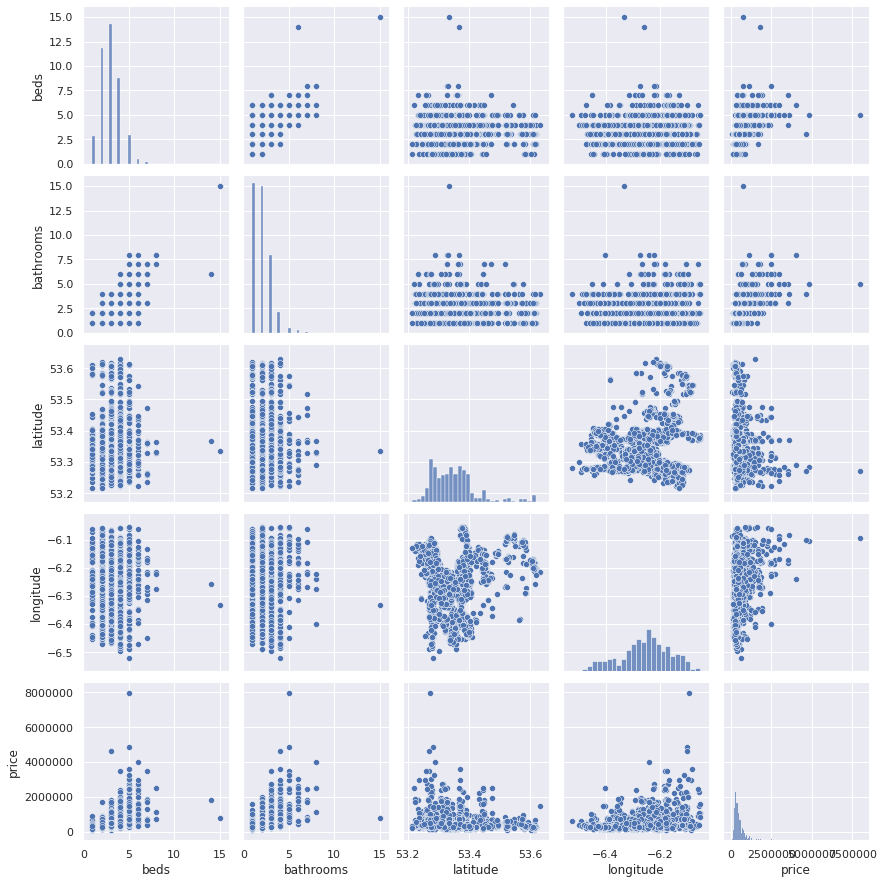

In [46]:
sns.pairplot(data=df_train_new[['beds','bathrooms', 'latitude', 'longitude', 'price']])

Latitude:
* 53.35 is approximately the river Liffey, so the division between South and North side. Increasing is further North.<br>

Longitude
* -6.35 is approximately Whitehall so further East is lower and these would include some generally more expensive areas such as Clontarf, Howth, Ballsbridge etc. So this would somewhat correlate with generally know trends.

There is a more obvious relationship between the price and the number of beds.

# Piecewise Regression <a id='piecewise_regression'></a>
The first part of this task is to apply a full model and then use subsets of the data to create clusters and apply a model to each of those. I would like to see if there are methods that aid in determining if certain features are more important than others to help in finding the most sutiable ones.

#### Using RandomForest for feature importance selection
Suggestion from Carlos

Features left in dataset
 ['area', 'bathrooms', 'beds', 'ber_classification', 'latitude', 'longitude', 'price', 'property_type']


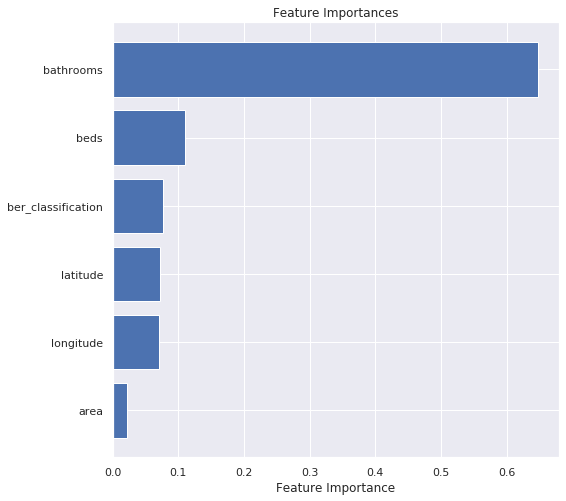

In [47]:
print("Features left in dataset\n {}".format(list(df_train_new.columns.values)))

# Need numerical values, so drop area
tmp_data = df_train_new.drop('area', axis=1).values
num_rows, num_cols = tmp_data.shape

model = RandomForestRegressor(random_state=8, max_depth=8)
X_orig = tmp_data[:,0:(num_cols -1)]
y_orig = tmp_data[:,(num_cols - 1)]
      
model.fit(X_orig, y_orig)

features = df_train_new.drop('price', axis=1).columns
importances = model.feature_importances_
indices = np.argsort(importances)[-10:]

sns.set(rc={'figure.figsize':(8,8)})
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], align='center')#, width=1)
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Feature Importance')
plt.show()

#### Using ExtraTreesClassifier for feature importance selection
Using this as another method to compare to the above - a second opinion.

[0.08102237 0.18642827 0.12406914 0.20615477 0.19053119 0.21179426]


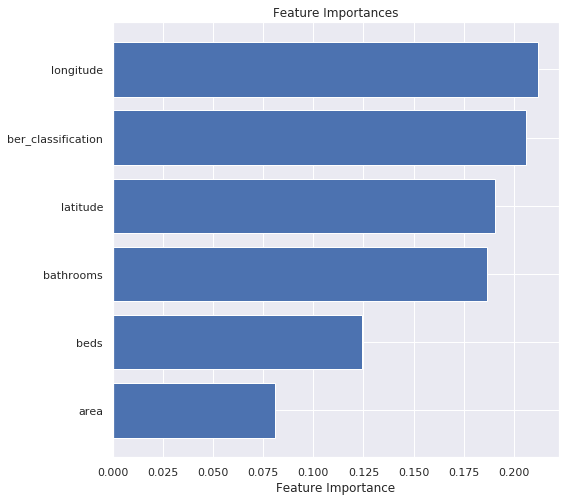

In [48]:
extra_tmp_data = df_train_new.drop('area', axis=1).values
num_rows, num_cols = extra_tmp_data.shape

X_orig = extra_tmp_data[:,0:(num_cols -1)]
y_orig = extra_tmp_data[:,(num_cols - 1)]

model = ExtraTreesClassifier(n_estimators=10)
model.fit(X_orig, y_orig)

print(model.feature_importances_)
features = df_train_new.drop('price', axis=1).columns
importances = model.feature_importances_
indices = np.argsort(importances)[-10:]

sns.set(rc={'figure.figsize':(8,8)})
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Feature Importance')
plt.show()

I note the different results that the 2 estimators gave. They are both show that `longitude` and `latitude` are closly related and that `area` is the lowest in terms of importance.

## Apply a full model <a id='apply_full_model'></a>
Now apply all of the features you are going to use to see how they perform together. We have been given 3 datasets, including 1 training and 1 testing, so I don't see the need to split the training set like others are doing.

In [49]:
# select some features columns just for the baseline model
# assume not all of the features are informative or useful

featrain = ['beds','bathrooms', 'latitude','longitude', 'ber_classification', 'price']

# dropna: remove missing values
df_subset_train = df_train_new[featrain].dropna(axis=0)

# Test data
featest = ['beds', 'bathrooms', 'latitude','longitude', 'ber_classification']
df_subset_test = df_test_new[featest].dropna(axis=0)

# cost
df_cost = df_true_cost[df_true_cost.index.isin(df_subset_test.index)]

In [50]:
print('Number of nan in df_subset_train dataset: ',df_subset_train.isnull().sum().sum())
print('Number of nan in df_subset_test dataset: ',df_subset_test.isnull().sum().sum())

Number of nan in df_subset_train dataset:  0
Number of nan in df_subset_test dataset:  0


Quick check on what we are going to use

In [51]:
df_subset_train.describe()

,beds,bathrooms,latitude,longitude,ber_classification,price
count,2267.000000,2267.000000,2267.000000,2267.000000,2267.000000,2.267000e+03
mean,3.011028,2.029996,53.353191,-6.255785,9.880018,5.295638e+05
std,1.185884,1.105622,0.077369,0.091700,3.139685,4.492461e+05
min,1.000000,1.000000,53.215264,-6.521183,1.000000,1.000000e+05
25%,2.000000,1.000000,53.294066,-6.309154,8.000000,2.950000e+05
50%,3.000000,2.000000,53.342393,-6.247240,10.000000,3.950000e+05
75%,4.000000,3.000000,53.384625,-6.189673,12.000000,5.950000e+05
max,15.000000,15.000000,53.630588,-6.054719,16.000000,7.950000e+06


In [52]:
df_subset_test.describe()

,beds,bathrooms,latitude,longitude,ber_classification
count,444.000000,444.000000,444.000000,444.000000,444.000000
mean,2.952703,1.988739,53.354377,-6.247194,9.885135
std,1.108154,1.039777,0.082288,0.089006,3.144791
min,0.000000,0.000000,53.221348,-6.496987,2.000000
25%,2.000000,1.000000,53.294817,-6.296588,8.000000
50%,3.000000,2.000000,53.339547,-6.243265,10.000000
75%,4.000000,3.000000,53.380353,-6.183723,12.000000
max,7.000000,8.000000,53.619775,-6.064874,16.000000


Below is creating the testing & training set. I have not removed `price` before now as below will do that and set it as the training `ys_train` value.<br>
The `[:,0:-1]` is using integer index location and slicing, so it is taking all from that array except the last value (-1), so based on the order I have above, that would remove the `price`.

In [53]:
# train set, input columns
Xs_train = df_subset_train.iloc[:,0:-1].values
print("Training set \n {}".format(Xs_train))

# train set, output column is price
ys_train = df_subset_train.iloc[:,-1].values.reshape(-1,1)
print("Training test set \n {}".format(ys_train))

# test set, input columns
Xs_test = df_subset_test.iloc[:,0:].values
print("Testing set \n {}".format(Xs_test))

# test set, output column, cost
y_test = df_cost.Expected.values

Training set 
 [[ 5.          3.         53.40045411 -6.44573026  3.        ]
 [ 4.          4.         53.31641013 -6.38521365  3.        ]
 [ 5.          3.         53.40141406 -6.44663439  3.        ]
 ...
 [ 2.          1.         53.346098   -6.276856    9.        ]
 [ 3.          2.         53.273518   -6.1785      9.        ]
 [ 3.          2.         53.310073   -6.325158   11.        ]]
Training test set 
 [[935000.]
 [485000.]
 [935000.]
 ...
 [299000.]
 [495000.]
 [525000.]]
Testing set 
 [[ 4.        2.       53.566881 -6.101148 15.      ]
 [ 3.        2.       53.362992 -6.452909  7.      ]
 [ 4.        3.       53.454198 -6.262964  6.      ]
 ...
 [ 3.        1.       53.391619 -6.205157 15.      ]
 [ 4.        2.       53.360578 -6.183701 13.      ]
 [ 2.        2.       53.366827 -6.248329  7.      ]]


In [54]:
# StandardScaler() will normalize the features i.e. each column of X, 
# so, each column/feature/variable will have μ = 0 and σ = 1
sc = StandardScaler()

# hstack will concatenation along the second axis
Xss_train = np.hstack([Xs_train, Xs_train[:,[2]]**2])
xscaler = sc.fit(Xss_train)
Xn_train = xscaler.transform(Xss_train)

In [55]:

Xss_test = np.hstack([Xs_test, Xs_test[:,[2]]**2])
Xn_test = xscaler.transform(Xss_test)

In [56]:

ylog = np.log(ys_train.astype('float'))

yscaler = sc.fit(ylog)
yn_train = yscaler.transform(ylog)

Finished [100%]: Average Loss = 2,200


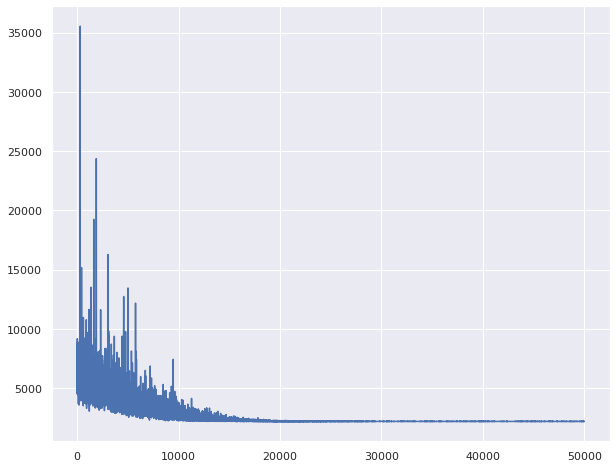

In [57]:
full_posterior, full_approximation = run_model(Xn_train, yn_train, num_iter, sample_size)

plt.figure(figsize=(10, 8))
plt.plot(full_approximation.hist);

In [58]:
# prediction
ll=np.mean(full_posterior['alpha']) + np.dot(np.mean(full_posterior['beta'],axis=0), Xn_test.T)
y_pred_BLR = np.exp(yscaler.inverse_transform(ll.reshape(-1,1)))[:,0]

full_model_mae = np.mean(abs(y_pred_BLR - y_test))
full_model_mape = np.mean(abs(y_pred_BLR - y_test) / y_test)

print("Full model prediction")
print("MAE = {}".format(full_model_mae))
print("MAPE = {}".format(full_model_mape))

Full model prediction
MAE = 173898.1038515428
MAPE = 0.26508831298731633


## Clustering <a id='clustering'></a>
In this section we will break the full dataset into smaller clusters based on features to see if they can reduce the overall MAE value seen above.

### Full Model Cluster <a id='full_model_cluster'></a>

In [59]:
# Remind us of the features and their order
print(featrain)

['beds', 'bathrooms', 'latitude', 'longitude', 'ber_classification', 'price']


In [60]:
# Training gaussian mixture model. Must equal the number of features I chose
gmm = GaussianMixture(n_components=6)

# clustering by features long & lat
ind=[2,3]
X_ind = np.vstack([Xn_train[:,ind], Xn_test[:,ind]])

# Gaussian Mixture
gmm.fit(X_ind)

GaussianMixture(n_components=6)

The orange dots are the centre of the clusters.

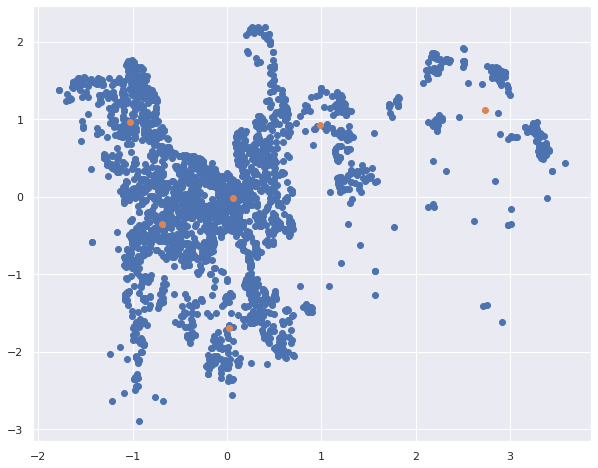

In [61]:
# plot blue dots
plt.figure(figsize=(10, 8))
plt.scatter(X_ind[:,0],X_ind[:,1])

# centroids:  orange dots
plt.scatter(gmm.means_[:,0],gmm.means_[:,1])

In [62]:
np.max(ys_train)

7950000.0

## Cluster setup <a id='cluster_setup'></a>
Now setup the training and testing clusters.

#### Training clusters

In [63]:
# train clusters
clusters_train = gmm.predict(Xn_train[:,ind])
unique_train, counts_train = np.unique(clusters_train, return_counts=True)
dict(zip(unique_train, counts_train))

print("{} {}".format(unique_train, counts_train))

[0 1 2 3 4 5] [774 214 422 372 334 151]


#### Testing clusters

In [64]:
# test clusters
clusters_test = gmm.predict(Xn_test[:,ind])
unique_test, counts_test = np.unique(clusters_test, return_counts=True)
dict(zip(unique_test, counts_test))

print("{} {}".format(unique_test, counts_test))

[0 1 2 3 4 5] [154  35  88  81  48  38]


## Simulations and Piecewise Model <a id='simulations'></a>

Running piecewise regression on a number of clusters to see if they produce a better outcome than the full single model above.

#### Cluster 0  <a id='cluster_0'></a>

Finished [100%]: Average Loss = 769.95


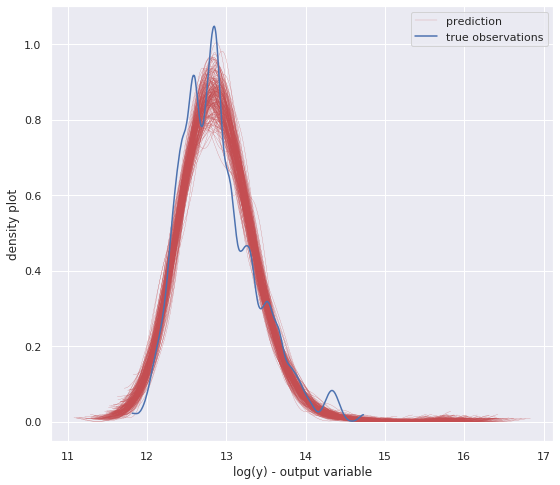

In [65]:
ylog0, yscaler, Xn0, yn0, Xtestn0, yscaler0 = train_cluster(Xn_train, Xn_test, 0)
cl0_posterior, cl0_approximation = run_model(Xn0, yn0, num_iter, sample_size)
cluster_sim(cl0_posterior, Xn0, ylog0, num_samples=num_of_clust_samples)

#### Cluster 1  <a id='cluster_1'></a>

Finished [100%]: Average Loss = 220.81


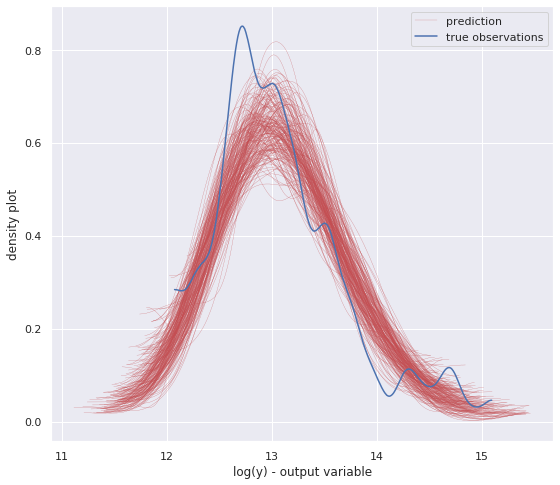

In [66]:
ylog1, yscaler, Xn1, yn1, Xtestn1, yscaler1 = train_cluster(Xn_train, Xn_test, 1)
cl1_posterior, cl1_approximation = run_model(Xn1, yn1, num_iter, sample_size)
cluster_sim(cl1_posterior, Xn1, ylog1, num_samples=num_of_clust_samples)

#### Cluster 2   <a id='cluster_2'></a>

Finished [100%]: Average Loss = 341.15


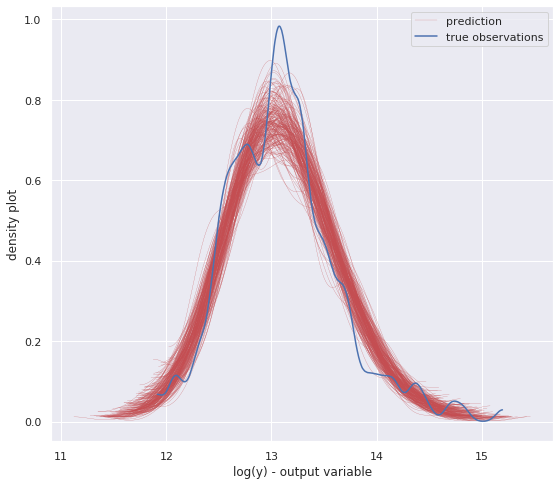

In [67]:
ylog2, yscaler, Xn2, yn2, Xtestn2, yscaler2 = train_cluster(Xn_train, Xn_test, 2)
cl2_posterior, cl2_approximation = run_model(Xn2, yn2, num_iter, sample_size)
cluster_sim(cl2_posterior, Xn2, ylog2, num_samples=num_of_clust_samples)

#### Cluster 3  <a id='cluster_3'></a>

Finished [100%]: Average Loss = 357.66


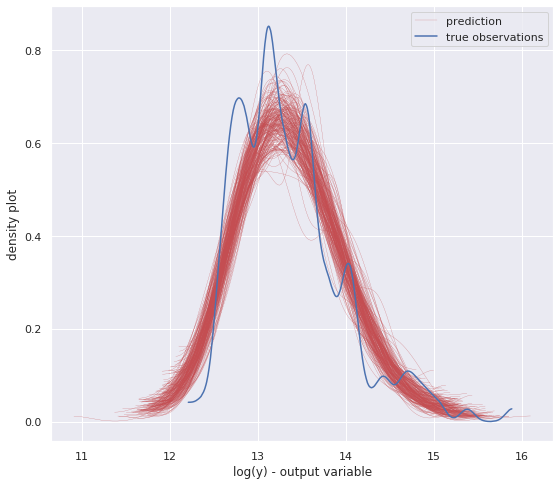

In [68]:
ylog3, yscaler, Xn3, yn3, Xtestn3, yscaler3 = train_cluster(Xn_train, Xn_test, 3)
cl3_posterior, cl3_approximation = run_model(Xn3, yn3, num_iter, sample_size)
cluster_sim(cl3_posterior, Xn3, ylog3, num_samples=num_of_clust_samples)

#### Cluster 4  <a id='cluster_4'></a>

Finished [100%]: Average Loss = 358.18


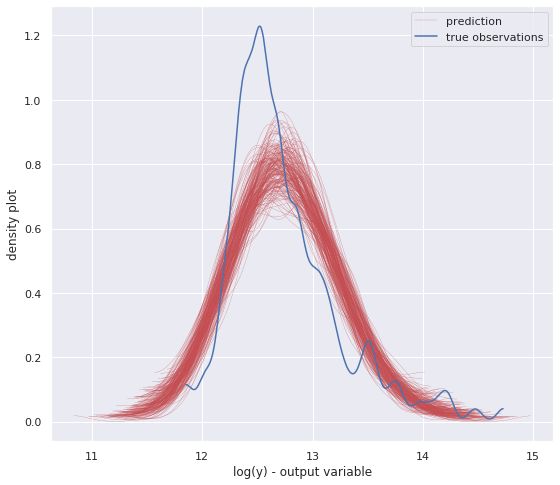

In [69]:
ylog4, yscaler, Xn4, yn4, Xtestn4, yscaler4 = train_cluster(Xn_train, Xn_test, 4)
cl4_posterior, cl4_approximation = run_model(Xn4, yn4, num_iter, sample_size)
cluster_sim(cl4_posterior, Xn4, ylog4, num_samples=num_of_clust_samples)

#### Cluster 5  <a id='cluster_5'></a>

Finished [100%]: Average Loss = 198.72


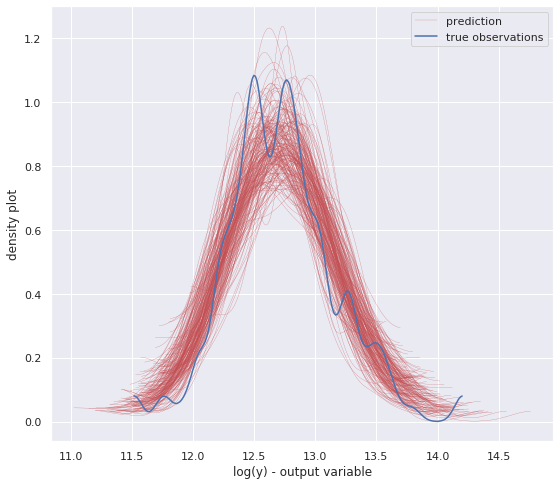

In [70]:
ylog5, yscaler, Xn5, yn5, Xtestn5, yscaler5 = train_cluster(Xn_train, Xn_test, 5)
cl5_posterior, cl5_approximation = run_model(Xn5, yn5, num_iter, sample_size)
cluster_sim(cl5_posterior, Xn5, ylog5, num_samples=num_of_clust_samples)

## Overall <a id='overall_ppc_train'> </a> 

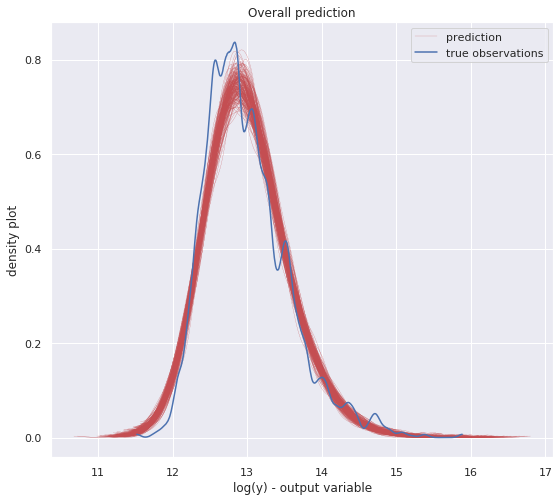

In [71]:
# posteriors
Ypred0 = ppc(cl0_posterior['alpha'],cl0_posterior['beta'],cl0_posterior['sigma_n'],
             Xn0, nsamples=num_of_clust_samples)
Ypred1 = ppc(cl1_posterior['alpha'],cl1_posterior['beta'],cl1_posterior['sigma_n'],
             Xn1, nsamples=num_of_clust_samples)
Ypred2 = ppc(cl2_posterior['alpha'],cl2_posterior['beta'],cl2_posterior['sigma_n'],
             Xn2, nsamples=num_of_clust_samples)
Ypred3 = ppc(cl3_posterior['alpha'],cl3_posterior['beta'],cl3_posterior['sigma_n'],
             Xn3, nsamples=num_of_clust_samples)
Ypred4 = ppc(cl4_posterior['alpha'],cl4_posterior['beta'],cl4_posterior['sigma_n'],
             Xn4, nsamples=num_of_clust_samples)
Ypred5 = ppc(cl5_posterior['alpha'],cl5_posterior['beta'],cl5_posterior['sigma_n'],
             Xn5, nsamples=num_of_clust_samples)

# simulation
Ypred = np.hstack([yscaler0.inverse_transform(Ypred0),
                 yscaler1.inverse_transform(Ypred1),
                 yscaler2.inverse_transform(Ypred2),
                 yscaler3.inverse_transform(Ypred3),
                 yscaler4.inverse_transform(Ypred4),
                 yscaler5.inverse_transform(Ypred5) ])

ylog=np.vstack([ylog0, ylog1, ylog2, ylog3, ylog4, ylog5])
plot_redictions(Ypred, ylog, "Overall prediction")


## Test set performance <a id='test_set_perf'></a>

In [72]:
# Cluster 0
y_pred_BLR0 = np.exp(yscaler0.inverse_transform(np.mean(cl0_posterior['alpha']) 
              + np.dot(np.mean(cl0_posterior['beta'],axis=0), Xtestn0.T)))

print("Cluster 0 size is {} MAE = {}\tMAPE = {}".format(np.sum(clusters_test==0),
    (np.mean(abs(y_pred_BLR0 - y_test[clusters_test==0]))),
    (np.mean(abs(y_pred_BLR0 - y_test[clusters_test==0]) /y_test[clusters_test==0])) ) )

# Cluster 1
y_pred_BLR1 = np.exp(yscaler1.inverse_transform(np.mean(cl1_posterior['alpha']) 
              + np.dot(np.mean(cl1_posterior['beta'],axis=0), Xtestn1.T)))

print("Cluster 1 size is {} MAE = {}\tMAPE = {}".format(np.sum(clusters_test==1),
    (np.mean(abs(y_pred_BLR1 - y_test[clusters_test==1]))),
    (np.mean(abs(y_pred_BLR1 - y_test[clusters_test==1]) /y_test[clusters_test==1])) ) )

# Cluster 2
y_pred_BLR2 = np.exp(yscaler2.inverse_transform(np.mean(cl2_posterior['alpha']) 
              + np.dot(np.mean(cl2_posterior['beta'],axis=0), Xtestn2.T)))

print("Cluster 2 size is {} MAE = {}\tMAPE = {}".format(np.sum(clusters_test==2),
    (np.mean(abs(y_pred_BLR2 - y_test[clusters_test==2]))),
    (np.mean(abs(y_pred_BLR2 - y_test[clusters_test==2]) /y_test[clusters_test==2])) ) )

# Cluster 3
y_pred_BLR3 = np.exp(yscaler3.inverse_transform(np.mean(cl3_posterior['alpha']) 
              + np.dot(np.mean(cl3_posterior['beta'],axis=0), Xtestn3.T)))

print("Cluster 3 size is {} MAE = {}\tMAPE = {}".format(np.sum(clusters_test==3),
    (np.mean(abs(y_pred_BLR3 - y_test[clusters_test==3]))),
    (np.mean(abs(y_pred_BLR3 - y_test[clusters_test==3]) /y_test[clusters_test==3])) ) )

# Cluster 4
y_pred_BLR4 = np.exp(yscaler4.inverse_transform(np.mean(cl4_posterior['alpha']) 
              + np.dot(np.mean(cl4_posterior['beta'],axis=0), Xtestn4.T)))

print("Cluster 4 size is {} MAE = {}\tMAPE = {}".format(np.sum(clusters_test==4),
    (np.mean(abs(y_pred_BLR4 - y_test[clusters_test==4]))),
    (np.mean(abs(y_pred_BLR4 - y_test[clusters_test==4]) /y_test[clusters_test==4])) ) )

# Cluster 5
y_pred_BLR5 = np.exp(yscaler5.inverse_transform(np.mean(cl5_posterior['alpha']) 
              + np.dot(np.mean(cl5_posterior['beta'],axis=0), Xtestn5.T)))

print("Cluster 5 size is {} MAE = {}\tMAPE = {}\n".format(np.sum(clusters_test==5),
    (np.mean(abs(y_pred_BLR5 - y_test[clusters_test==5])) ),
    (np.mean(abs(y_pred_BLR5 - y_test[clusters_test==5]) /y_test[clusters_test==5])) ) )


# Combined MAE
joint_mae = np.hstack([abs(y_pred_BLR0 - y_test[clusters_test==0]),
                 abs(y_pred_BLR1 - y_test[clusters_test==1]),
                 abs(y_pred_BLR2 - y_test[clusters_test==2]),
                 abs(y_pred_BLR3 - y_test[clusters_test==3]),
                 abs(y_pred_BLR4 - y_test[clusters_test==4]),
                 abs(y_pred_BLR5 - y_test[clusters_test==5]) ])

# Combined MAPE
joint_mape = np.hstack([abs(y_pred_BLR0 - y_test[clusters_test==0]) / y_test[clusters_test==0],
                 abs(y_pred_BLR1 - y_test[clusters_test==1]) / y_test[clusters_test==1],
                 abs(y_pred_BLR2 - y_test[clusters_test==2]) / y_test[clusters_test==2],
                 abs(y_pred_BLR3 - y_test[clusters_test==3]) / y_test[clusters_test==3],
                 abs(y_pred_BLR4 - y_test[clusters_test==4]) / y_test[clusters_test==4],
                 abs(y_pred_BLR5 - y_test[clusters_test==5]) / y_test[clusters_test==5] ])

print("Full Regression Model MAE = {}".format(full_model_mae))
print("Full Regression Model MAPE = {}\n".format(full_model_mape))
print("Single Piecewise Regression Model MAE = {}".format(np.mean(joint_mae)))
print("Single Piecewise Regression Model MAPE = {}\n".format(np.mean(joint_mape)))


Cluster 0 size is 154 MAE = 124379.35097342919	MAPE = 0.2359673265084256
Cluster 1 size is 35 MAE = 164793.3793745328	MAPE = 0.23138042663398858
Cluster 2 size is 88 MAE = 156990.84847527466	MAPE = 0.17681305779469872
Cluster 3 size is 81 MAE = 253755.36559941492	MAPE = 0.25265880223414167
Cluster 4 size is 48 MAE = 111959.03840181236	MAPE = 0.23721504055326256
Cluster 5 size is 38 MAE = 96602.32377589692	MAPE = 0.239649091373885

Full Regression Model MAE = 173898.1038515428
Full Regression Model MAPE = 0.26508831298731633

Single Piecewise Regression Model MAE = 153911.01295983017
Single Piecewise Regression Model MAPE = 0.22737653761295124



**M**ean **A**bsolute **E**rror is the size of the difference between a prediction and the true value of that prediction. There is a small drop between the mean of the clusters and the full model above, with cluster 1 showing the largest drop but that cluster does generally have the smallest size.

### PPC on the Test set <a id='ppc_test_set'> </a> 

Posterior predictive checks is seeing if the model will give you valid predictions.


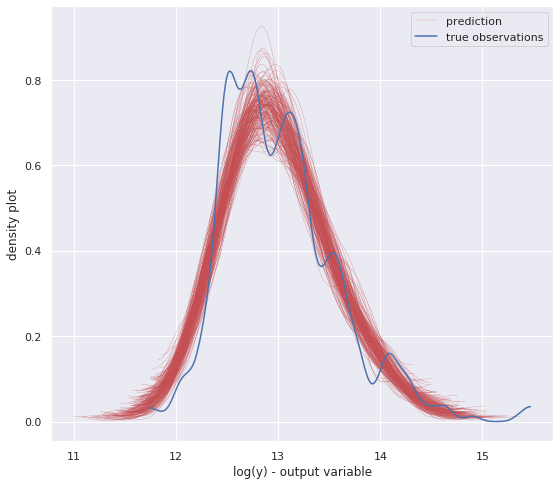

In [73]:

# posteriors
YTpred0 = ppc(cl0_posterior['alpha'],cl0_posterior['beta'],cl0_posterior['sigma_n'],
             Xtestn0, nsamples=num_of_clust_samples)
YTpred1 = ppc(cl1_posterior['alpha'],cl1_posterior['beta'],cl1_posterior['sigma_n'],
             Xtestn1, nsamples=num_of_clust_samples)
YTpred2 = ppc(cl2_posterior['alpha'],cl2_posterior['beta'],cl2_posterior['sigma_n'],
             Xtestn2, nsamples=num_of_clust_samples)
YTpred3 = ppc(cl3_posterior['alpha'],cl3_posterior['beta'],cl3_posterior['sigma_n'],
             Xtestn3, nsamples=num_of_clust_samples)
YTpred4 = ppc(cl4_posterior['alpha'],cl4_posterior['beta'],cl4_posterior['sigma_n'],
             Xtestn4, nsamples=num_of_clust_samples)
YTpred5 = ppc(cl5_posterior['alpha'],cl5_posterior['beta'],cl5_posterior['sigma_n'],
             Xtestn5, nsamples=num_of_clust_samples)

# simulation
YTpred = np.hstack([ yscaler0.inverse_transform(YTpred0),
                 yscaler1.inverse_transform(YTpred1),
                 yscaler2.inverse_transform(YTpred2),
                 yscaler3.inverse_transform(YTpred3),
                 yscaler4.inverse_transform(YTpred4),
                 yscaler5.inverse_transform(YTpred5) ])

plot_redictions(YTpred, np.log(y_test))


In [74]:
print("Finish time {}".format(datetime.datetime.now().time()))

Finish time 11:26:46.878793


# Summary
### Basic understanding

The basic idea behind piecewise regression is splitting the dataset up into different sections to see if those sections follow different trends than the entire dataset considered in its entirety. You try to model those sections in pieces with different regression models to see if they are better for that particular section(cluster).

### General

There was a lot of time spent on the data preparation, from examining the details of each feature, to deciding what to drop and what to apply various encoding techniques. This part of the etivity proved to be the most important part and re-enforced the importance of EDA and data preparation.

For the data preparation (see section [data_preparation](#data_preparation)), I dropped `ad_id`, `description_block`, `environment`, `county`, `no_of_units`, `facility`, `property_category`, `features` and `surface` after examining their contents and the number of unique times they appeared within the dataset. I do note that the `ad_id` is linked from the true cost dataset to the test dataset. More details of each feature dropped and why is detailed in the above section. For the conversion of any textual data to numerical, I went with simple mappings for the 2 features (`property_type` and `ber_classification`) as I found the application of other techniques added no obvious benefit to feature importance selection or to the resulting MAE/MAPE values.

In the feature importance section, I tried RandomForest as suggested by Carlos and I also tried ExtraTreesClassifier for comparison. The results differ but they do show a similarity in how close each feature is to the other.

Resulting from the data preparation, I have decided on 6 features (`latitude`, `longitude`, `beds`, `bathrooms`, `property_type` and `ber_classification`) for the [piecewise_regression](#piecewise_regression). These are listed in the [apply_full_model](#apply_full_model) section. These were selected by using the methods stated above.

Initially, it generated a Mean Absolute Error of 209147 and Mean Absolute Percentage Error (a measure of the prediction accuracy) of over 0.27. When I dropped the `property_type` the new full model values were MAE =  210594.62820959283 and MAPE = 0.28071419267212905.

I then encoded `ber_classification` with simple numnerical values in section [continue_cleaning](#continue_cleaning) and added `property_type` back in. The overall model MAE droped to ~175k with the clusters dropping to ~152k. These are approximately the lowest values I could achieve during all the tests and feature combinations I've tried. The results of this are just above the [clustering](#clustering) section. Each of the piecewise  clusters can be seen under the [simulations](#simulations) section.

<br>
With each execution, each of the clusters is using a different size and producing different error values but what is detailed below is broadly inline with the observations for the different values used:

Increasing the number of iterations from 50,000 to 70,000 brought no improvement in the error rates. Below is a repesentitive example from a 70,000 test:

* Cluster 0 size is 35 	MAE = 161681.02500616055 MAPE = 0.2254488594044929
* Cluster 1 size is 154 MAE = 124001.46360307878 MAPE = 0.2364195364111954
* Cluster 2 size is 38 	MAE = 96618.11558859936 MAPE = 0.24068366203480207
* Cluster 3 size is 81 	MAE = 253730.4766585157 MAPE = 0.2526316082765556
* Cluster 4 size is 88 	MAE = 156556.60729435596 MAPE = 0.1742344576563165
* Cluster 5 size is 48  MAE = 111835.55260643503 MAPE = 0.23683382455706828

* Full Regression Model MAE = 174065.58053375152
* Full Regression Model MAPE = 174065.58053375152

* Single Piecewise Regression Model MAE = 153431.9960333525
* Single Piecewise Regression Model MAPE = 0.22659710352860352

I also reduced the number of iterations to 40,000 and decreased the customer sample size to 100. That produced the following results:

* Cluster 0 size is 81 	MAE = 252033.03074260158 MAPE = 0.24860063290245035
* Cluster 1 size is 144 MAE = 116022.53410976997 MAPE = 0.2323112063587608
* Cluster 2 size is 34 	MAE = 173017.5903320099 MAPE = 0.24142772548518046
* Cluster 3 size is 49 	MAE = 114084.72955842217 MAPE = 0.23788394473650626
* Cluster 4 size is 38 	MAE = 97027.01380737392 MAPE = 0.2434652560414254
* Cluster 5 size is 98  MAE = 158300.17774655568 MAPE = 0.17847777979736323

* Full Regression Model MAE = 173994.57113890006
* Full Regression Model MAPE = 173994.57113890006

* Single Piecewise Regression Model MAE = 152691.69857083625
* Single Piecewise Regression Model MAPE = 0.2256685204708575

As can be seen, there is a slight improvement in the error rate. I increased the customer sample size to 1000 and this produced the following:

* Cluster 0 size is 87 	MAE = 154488.88941272884 MAPE = 0.17309886094820306
* Cluster 1 size is 35 	MAE = 169642.59717314786 MAPE = 0.2383725901748153
* Cluster 2 size is 81 	MAE = 253300.5929193689 MAPE = 0.2509438742858376
* Cluster 3 size is 48 	MAE = 112095.3346256558 MAPE = 0.23599861630023647
* Cluster 4 size is 38 	MAE = 96518.34147545039 MAPE = 0.2397501119878071
* Cluster 5 size is 155 MAE = 125540.98688841748 MAPE = 0.23733760894889586

* Full Regression Model MAE = 173930.7216740213
* Full Regression Model MAPE = 173930.7216740213

* Single Piecewise Regression Model MAE = 154059.6808834229
* Single Piecewise Regression Model MAPE = 0.22737581666845028

As can be seen, there is a slight increase in the error rate. I decreased the customer sample size to 200 and this produced the following:

* Cluster 0 size is 38 	MAE = 96485.51771905906 MAPE = 0.23822951582440532
* Cluster 1 size is 145 MAE = 115485.95480319456 MAPE = 0.23080706745346996
* Cluster 2 size is 49 	MAE = 113712.62479965776 MAPE = 0.23760033098031905
* Cluster 3 size is 96 	MAE = 160073.63730163543 MAPE = 0.179785116493536
* Cluster 4 size is 35 	MAE = 169426.30516646124 MAPE = 0.23971258079430352
* Cluster 5 size is 81 MAE = 253208.28798572926 MAPE = 0.25178383626627754

* Full Regression Model MAE = 173968.07183307467
* Full Regression Model MAPE = 173968.07183307467

* Single Piecewise Regression Model MAE = 152681.7408189142
* Single Piecewise Regression Model MAPE = 0.22568911001996564

The above seems to consistently produce the best values overall, so 40,000 and 200 are final values I am going to use. A summary of the last results can seen just above. The ~173/4k results for the full model is more consistent than the clustering results, as I have seen results from ~152k - 165k depending on the test with the same set of features.

The [test_set_perf](#test_set_perf) section is measuring the performance of the clusters against the test set. The final PPC [ppc_test_set](#ppc_test_set) section is showing the posterior predictive check using the test data as a comparison to the ppc on the training data in section [overall_ppc_train](#overall_ppc_train).


### Peer contribution
As with other etivities, the contribution from the group members has been invaluable. Below summarises the most important contributions I learned from:
* Providing results from trying t-SNE, MDS and PCA.
* Suggesting how I could try to use certain algorithms for locating important features - RandomForest etc.
* The results they were seeing when certain values were included/excluded (E.G surface).
* The questions raised in relation to the splitting of the training and validation set.

### References
#### Websites
#### https://twiecki.io/blog/2016/06/01/bayesian-deep-learning/
#### https://twiecki.io/blog/2014/03/17/bayesian-glms-3/
#### https://www.cs.cornell.edu/courses/cs4110/2016fa/lectures/lecture33.html
#### http://www.henry.k12.ga.us/ugh/apstat/chapternotes/7supplement.html
#### https://online.stat.psu.edu/stat414/lesson/14/14.1
#### https://machinelearningmastery.com/one-hot-encoding-for-categorical-data/
#### https://stats.stackexchange.com/questions/115157/what-are-posterior-predictive-checks-and-what-makes-them-useful
#### https://machinelearningmastery.com/feature-selection-machine-learning-python/
#### https://machinelearningmastery.com/feature-importance-and-feature-selection-with-xgboost-in-python/

#### Books/Papers etc
#### https://www.colorado.edu/amath/sites/default/files/attached-files/ch3_0.pdf

In [75]:
#%%capture
#!wget -nc https://raw.githubusercontent.com/brpy/colab-pdf/master/colab_pdf.py
#from colab_pdf import colab_pdf
#colab_pdf('ET5003_Etivity2_JohnHayes_9309888.ipynb')